In [37]:
from pylab import *
from scipy.ndimage import filters

# Bitwise Encoding

When we modulate a digital signal, we first need to turn it into a string of ones and zeros. This can be a very complicated process in general, using compression, checksums, and error correction.

Here, we just convert text strings into a bit stream.

In [38]:
def encode(s):
    result = zeros(len(s)*8)
    for i in range(len(s)):
        c = ord(s[i])+512 # add a sync bit
        for j in range(8):
            result[i*8+j] = (c&(1<<(7-j))>0)
    return result

def decode(m):
    result = ""
    for i in range(0,len(m)-7,8):
        c = 0
        for j in range(8):
            if m[i+j]: c += (1<<(7-j))
        result += chr(c&0xff)
    return result

Let's try encoding a simple message as a bitstream, and then decoding it again.

In [39]:
message = encode("The quick brown fox jumped over the lazy dogs.")
print decode(message)
plot(message[:100])

The quick brown fox jumped over the lazy dogs.


# Signal Generation

An obvious encoding is as a sequence of voltages. However, such an encoding requires precise synchronization for decoding, and if there is a sequence of null characters, such an encoding would likely lose synchronization.

In [40]:
signal = tile(message.reshape(len(message),1),[1,400]).flatten()
plot(signal[:5000])

Here is a better encoding. It uses positive to negative and negative to positive transitions, separated by quiescent inputs.

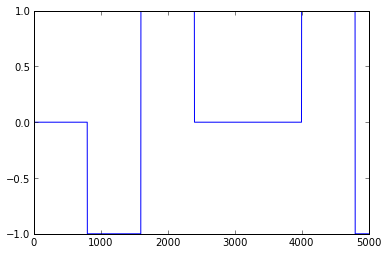

In [41]:
signal = concatenate([[0,1,-1,0] if m else [0,-1,1,0] for m in message])
signal = 1.0*tile(signal.reshape(len(signal),1),[1,800]).flatten()
plot(signal[:5000])

# Signal Decoding

Decoding should usually be resistant to noise

In [42]:
noisy = signal+0.2*randn(len(signal))
plot(noisy[:5000])

How do we carry out the decoding? Remember that the value of each bit is given by the direction of the transition (-1 to 1, 1 to -1). We can find those transitions by taking gradients of the smoothed signal.

In [43]:
d = 1.0*signal[::16]
d = filters.gaussian_filter(d,16,1)
plot(d[:1000])
plot((amax(d)*signal/amax(signal))[:16000:16])

Now we still need to find the locations of the transitions. We can do this by filtering the absolute signal.

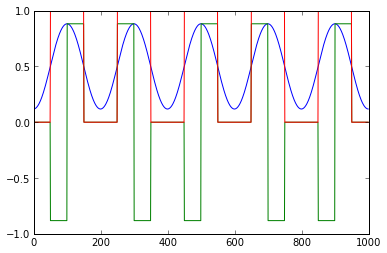

In [44]:
s = abs(1.0*signal[::16])
s = filters.gaussian_filter(s,32.0)
plot(s[:1000])
plot((amax(s)*signal/amax(signal))[:16000:16])
plot(abs(1.0*signal[:16000:16]))

Now we look up the sign at each of the locations of the peaks of the absolute signals.

In [45]:
locations = find(((s>roll(s,-1))*(s>=roll(s,1))))
signs = d[locations]
bits = 1*(signs<0)
print bits

[0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0
 0 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0
 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1
 1 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1
 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0
 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1
 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1
 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0
 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 0]


Finally, we decode the recovered bits to get back the original text.

In [46]:
print decode(bits)

The quick brown fox jumped over the lazy dogs.


Now let's wrap all of this up in a couple of functions.

In [19]:
def signal_bits(sig,subsample=1,nplot=0):
    sig = 1.0*sig[::subsample]
    d = filters.gaussian_filter(sig,16.0,1)
    if nplot>0: plot(d[:nplot]/amax(d))
    s = abs(1.0*sig)
    s = filters.gaussian_filter(s,32.0)
    if nplot>0: plot(s[:nplot]/amax(s))
    l = find(((s>roll(s,-1))*(s>=roll(s,1))*(s>amax(s)*0.5)))
    signs = d[l]
    return signs

def signal_decode(sig,subsample=1,nplot=0):
    signs = signal_bits(sig,subsample=subsample,nplot=nplot)
    bits = 1*(signs<0)
    return decode(bits)

print signal_decode(signal,subsample=16,nplot=1000)

The quick brown fox jumped over the lazy dogs.


# Frequency Modulation

Now we're going to perform frequency modulation.

Note that we change the instantaneous frequency, but accumulate the phase over time. If we just change the frequency discontinously, we'd get jumps in the output.

In [48]:
def modulate(f,b,signal):
    "Frequency modulation."
    fs = f+signal*b
    phis = add.accumulate(2*pi*fs)
    signal = sin(phis)
    return signal

Now let's create a modulated signal.

In [49]:
freq = 0.1
b = 0.02
modulated = modulate(freq,b,signal)

Let's add some amplitude modulation as well, mostly to show that frequency modulation is robust to such disturbances.

In [50]:
am = filters.gaussian_filter(randn(len(modulated)),10.0)
am /= amax(am)
modulated *= 1.0+0.3*am

In [51]:
plot(modulated[:2000])

# Decoding with Windowed Fourier Transform

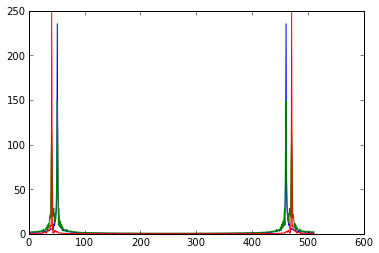

In [128]:
plot(abs(fft(modulated[0:512])))
plot(abs(fft(modulated[512:1024])))
plot(abs(fft(modulated[1024:1536])))

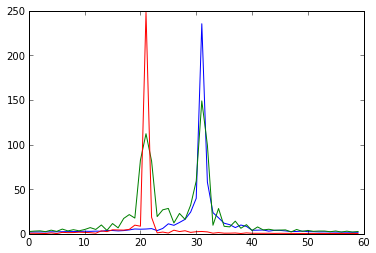

In [130]:
plot(abs(fft(modulated[0:512]))[20:80])
plot(abs(fft(modulated[512:1024]))[20:80])
plot(abs(fft(modulated[1024:1536]))[20:80])

First, compute spectra of length 512 (just like you did above) every 16 steps.  This will give you `len(modulated)/16` vectors of length 512. You can actually put these together into an image and display them. This is called a _spectrogram_. If you plot `result[:200,1:80].T`, it should look something like this.

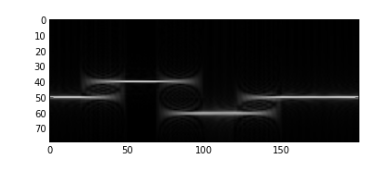

In [32]:
# YOUR CODE HERE; OUTPUT SHOULD LOOK LIKE THE IMAGE BELOW
axis("off"); imshow(imread("Figures/example-spectrogram.png"))

Next, try to recover the instantaneous value of the frequency from this. This gives the value of the modulating function. Plot it relative to the original signal; note that you need to subsample the original image, since the way you computed the spectrogram involved stepping along the original signal every 16 steps. This computation actually takes only one or two function calls to standard library functions. 

Note that the decoding works a lot better for arbitrary signals if you restrict the frequency bands where you are looking for spectral peaks to the range where the frequency modulation is actually occurring.

In [31]:
# YOUR CODE HERE; OUTPUT SHOULD LOOK LIKE THE IMAGE BELOW
axis("off"); imshow(imread("Figures/example-recovered.png"))

Finally, decode your signal.

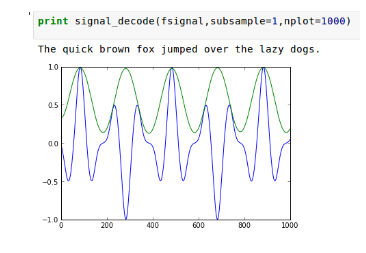

In [30]:
# YOUR CODE HERE; OUTPUT SHOULD LOOK LIKE THE IMAGE BELOW
axis("off"); imshow(imread("Figures/example-decoded.png"))

You have now gone through the steps of frequency demodulation using a FFT. This is actually something people do as part of software defined radio (e.g., GNU Radio).

Wrap up your function so that you can apply it to any modulated signal:

In [121]:
def fft_fm_demodulate(modulated,lo=1,hi=80):
    """Perform FM demodulation. Search for the peak frequencies is
    restricted to the frequency bins in the interval [lo,hi)."""
    pass

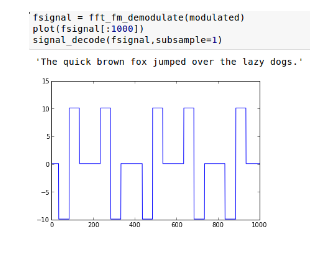

In [29]:
# YOUR CODE HERE; OUTPUT SHOULD LOOK LIKE THE IMAGE BELOW
axis("off"); imshow(imread("Figures/example-fmresult.png"))

# Decoding with Quadrature

Try to write a quadrature demodulator for the above signal. Have a look at the section on quadrature detectors here: 

http://en.wikipedia.org/wiki/Detector_(radio)#Frequency_and_phase_modulation_detectors

This is actually very simple (two lines of code) once you figure out how.

In [28]:
# YOUR CODE HERE; OUTPUT SHOULD LOOK LIKE THE IMAGE BELOW
axis("off"); imshow(imread("Figures/example-quadrature.png"))

In [20]:
print signal_decode(-decoded)

The quick brown fox jumped over the lazy dogs.


# Image Steganography

Steganography is the addition of hidden information to images. Let's pick a simple image.

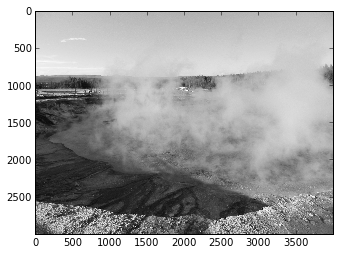

In [34]:
image = 1.0*mean(imread("geyser.jpg"),axis=2)
image /= amax(image)
gray()
imshow(image)

When viewed as a 1D signal, this image is much larger than our modulated signal.

In [52]:
print image.size,len(modulated)

12000000 1177600


Let's add our frequency-modulated signal to this image. Since this ends up in the sky region, it is actually quite visible.

In [53]:
stega = 0.0+image.ravel()
stega[:len(modulated)] += 0.1*modulated[:len(stega)]
stega.shape = image.shape
imshow(stega)

You should be able to decode the signal using your `fft_fm_demodulate` function

In [56]:
#fsignal = fft_fm_demodulate(stega.ravel()[:len(modulated)],lo=20)
#print signal_decode(fsignal,subsample=1)

Have a look at the decoded signal to get some idea of the quality.

In [60]:
#plot(fsignal[:5000])

Finally, try to see what level of modulation is minimally sufficient for recovering the encoded signal. Of course, this is highly image dependent.

In [ ]:
def roundtrip(l=0.01):
    stega = 0.0+image.ravel()
    stega[:len(modulated)] += l*modulated
    fsignal = fft_fm_demodulate(stega[:len(modulated)])
    return signal_decode(fsignal,subsample=1)

for l in exp(linspace(log(0.5),log(0.001),20)):
    print "%.4f"%l,roundtrip(l)